## Task Space (xy )to Joint Space (q1, q2)


In [1]:
import math

class FiveBL_Kinema :
    ## Data and performing kinematic calculations for a 5-bar linkage manipulator
    def __init__(self):
        self.d = 0.0 # cm
        self.l1 = 15.0 # cm
        self.l2 = 15.0 # cm
        self.l3 = 15.0 # cm
        self.l4 = 15.0 # cm

        '''
        Links:
        ground -> A (q1) -> l1 -> C -> l3 -> E (x, y)
        ground -> B (q2) -> l2 -> D -> l4 -> E (x, y)
        A -- l0 (d) -- B
        '''

    def inversePosition(self, x, y) -> tuple[float, float]:
        ''' Inverse kinematics for 5-bar linkage, returns (q1, q2) in radians '''
        # Calculate theta1 and theta2 based on (x, y)
        d = self.d
        l1 = self.l1
        l2 = self.l2
        l3 = self.l3
        l4 = self.l4

        ## Left side links
        r_A = math.sqrt(x**2 + y**2)
        alpha_A = math.atan2(y, x)
        cos_beta_A = (r_A**2 + l1**2 - l3**2) / (2 * r_A * l1)
        beta_A = math.acos(cos_beta_A)
        q1 = alpha_A + beta_A

        ## Right side links
        r_B = math.sqrt((x-d)**2 + y**2)
        alpha_B = math.atan2(y, x - d)
        cos_beta_B = (r_B**2 + l2**2 - l4**2) / (2 * r_B * l2)
        beta_B = math.acos(cos_beta_B)
        q2 = alpha_B - beta_B

        return (q1, q2)
    
    ## Helper function for Forward Kinematics
    def find_circle_intersection(self, x1, y1, x2, y2, r1, r2)-> tuple[float, float] : # where r1 = r2

        dx = x2 - x1
        dy = y2 - y1
        d = math.sqrt(dx**2 + dy**2)

        theta_1 = math.atan2(dy, dx)
        ang_C1 = math.acos((r1**2 + d**2 - r2**2)/ (2*r1*d))

        theta_r1 = theta_1 + ang_C1

        x_P1 = x1 + r1*math.cos(theta_r1)
        y_P1 = y1 + r1*math.sin(theta_r1)

        return (x_P1, y_P1)

    def forwardPosition(self, q1, q2) -> tuple[float, float]:
        ''' Forward kinematics for 5-bar linkage, returns (x, y) '''
        d = self.d
        l1 = self.l1
        l2 = self.l2
        l3 = self.l3
        l4 = self.l4

        # Position of point C
        x_C = l1 * math.cos(q1)
        y_C = l1 * math.sin(q1)

        # Position of point D
        x_D = d + l2 * math.cos(q2)
        y_D = l2 * math.sin(q2)

        # Find intersection of circles centered at C and D
        (x_E, y_E) = self.find_circle_intersection(x_C, y_C, x_D, y_D, l3, l4)

        return (x_E, y_E)
        



Forward Kinematics: x = -13.50 cm, y = 18.55 cm
Inverse Kinematics: q1 = 2.90 rad, q2 = 1.50 rad
Test points: [(-14.0, 4.0), (-14.0, 4.6), (-14.0, 5.2), (-14.0, 5.8), (-14.0, 6.4)] ...
Recalculated points: [(-14.000000000000004, 4.000000000000005), (-14.000000000000004, 4.599999999999998), (-14.000000000000004, 5.200000000000001), (-14.000000000000009, 5.800000000000001), (-14.000000000000005, 6.400000000000006)] ...


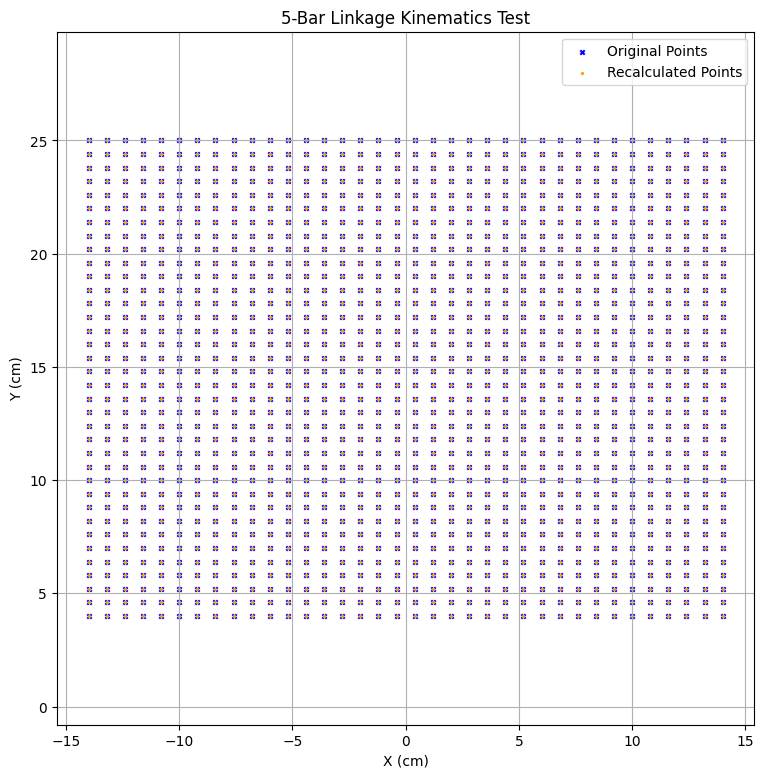

In [2]:
# isntantiate the kinematics class
fiveBL_Kinema = FiveBL_Kinema()

x, y = fiveBL_Kinema.forwardPosition(2.9, 1.5)
print(f"Forward Kinematics: x = {x:.2f} cm, y = {y:.2f} cm")
q1, q2 = fiveBL_Kinema.inversePosition(x, y)
print(f"Inverse Kinematics: q1 = {q1:.2f} rad, q2 = {q2:.2f} rad")

import numpy as np
## Test the class
# Create a list of (x, y) points within the reachable workspace
x_points = np.linspace(-14, 14, 36)
y_points = np.linspace(4, 25, 36)
test_points = [(float(x), float(y)) for x in x_points for y in y_points]
test_qs = [fiveBL_Kinema.inversePosition(x, y) for (x, y) in test_points]
recalced_points = [fiveBL_Kinema.forwardPosition(q1, q2) for (q1, q2) in test_qs]

# print the results
print(f"Test points: {test_points[:5]} ...")
print(f"Recalculated points: {recalced_points[:5]} ...")

# plot the results as scatter plot in xy space
import matplotlib.pyplot as plt
x_test, y_test = zip(*test_points)
x_recalc, y_recalc = zip(*recalced_points)
plt.figure(figsize=(9, 9))
plt.scatter(x_test, y_test, color='blue', marker='x', s=10, label='Original Points')
plt.scatter(x_recalc, y_recalc, color='orange', s=2, label='Recalculated Points')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('5-Bar Linkage Kinematics Test')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


## Joint Space to Cam Profile

In [3]:
def rotatePoint(theta, x, y) -> tuple[float, float]:
    ''' Rotate point (x, y) by angle theta (radians) around origin '''
    x_rot = x * math.cos(theta) - y * math.sin(theta)
    y_rot = x * math.sin(theta) + y * math.cos(theta)
    return (x_rot, y_rot)

In [4]:
class Cam_Kinema :
    ## Data and calculations for a cam-follower mechanism
    def __init__(self):
        self.l_follower = 10.0 # cm
        self.ang_offset_deg = 20.0 # deg
        self.ang_offset = math.radians(self.ang_offset_deg) # rad
        self.a = 10.5 # cm // distance from base to cam center

        '''
        phi : angle of cam
        psi : angle displacement of follower
        '''

    ## link 1 and follower 1
    def invertFollower1(self, psi, phi_cam=0) -> tuple[float, float]:
        '''Find xy of follower tip, given the displacement psi (rad) and cam angle phi_cam (rad)'''
        l_follower = self.l_follower
        a = self.a

        # Position of follower tip before rotation
        follower_x = l_follower * math.sin(psi)
        follower_y = a - l_follower * math.cos(psi)

        # Rotate by cam angle phi_cam
        (r_x, r_y) = rotatePoint(phi_cam, follower_x, follower_y)
        
        return (r_x, r_y)
    
    def get_f1_from_q1(self, q1, phi_cam=0) -> tuple[float, float]:
        ''' Get follower tip position from cam angle q1 '''
        psi1 = q1 - math.pi/2 - self.ang_offset
        return self.invertFollower1(psi1, phi_cam)

    ## link 2 and follower 2
    def invertFollower2(self, psi, phi_cam=0) -> tuple[float, float]:
        '''Find xy of follower tip, given the displacement psi (rad) and cam angle phi_cam (rad)'''
        l_follower = self.l_follower
        a = self.a

        # Position of follower tip before rotation
        follower_x = - l_follower * math.sin(psi)
        follower_y = a - l_follower * math.cos(psi)

        # Rotate by cam angle phi_cam
        (r_x, r_y) = rotatePoint(phi_cam, follower_x, follower_y)
        
        return (r_x, r_y)

    def get_f2_from_q2(self, q2, phi_cam=0) -> tuple[float, float]:
        ''' Get follower tip position from cam angle q2 '''
        psi2 = math.pi/2 - q2 - self.ang_offset
        return self.invertFollower2(psi2, phi_cam)




Test the Cam Class

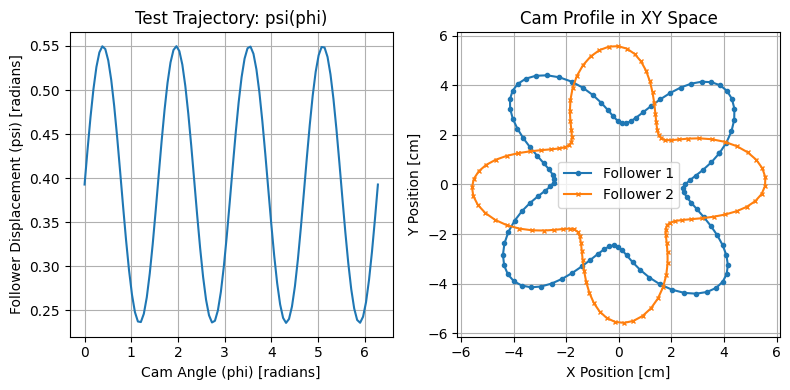

Cam profile points for Follower 1 (x, y):
[[ 3.82683432e+00  1.26120467e+00]
 [ 4.08978360e+00  1.68210008e+00]
 [ 4.28417627e+00  2.13967067e+00]
 [ 4.38976442e+00  2.60732236e+00]
 [ 4.39602265e+00  3.05460528e+00]
 [ 4.30225299e+00  3.45157945e+00]
 [ 4.11613376e+00  3.77272968e+00]
 [ 3.85133222e+00  3.99980601e+00]
 [ 3.52491161e+00  4.12334055e+00]
 [ 3.15512397e+00  4.14291898e+00]
 [ 2.75989430e+00  4.06647775e+00]
 [ 2.35599291e+00  3.90895469e+00]
 [ 1.95866426e+00  3.69058968e+00]
 [ 1.58138191e+00  3.43510681e+00]
 [ 1.23543551e+00  3.16793831e+00]
 [ 9.29193058e-01  2.91457581e+00]
 [ 6.67069250e-01  2.69905462e+00]
 [ 4.48414028e-01  2.54250520e+00]
 [ 2.66669689e-01  2.46167543e+00]
 [ 1.09198040e-01  2.46737424e+00]
 [-4.18722095e-02  2.56292403e+00]
 [-2.07598090e-01  2.74290040e+00]
 [-4.09078889e-01  2.99259797e+00]
 [-6.63667637e-01  3.28868350e+00]
 [-9.81295446e-01  3.60130851e+00]
 [-1.36179789e+00  3.89756973e+00]
 [-1.79398710e+00  4.14575435e+00]
 [-2.25679564

In [5]:
cam = Cam_Kinema()

# Generate test data for psi(phi) as a sine function
phi_vals = np.linspace(0, 2 * np.pi, 100)  # Cam angle from 0 to 2pi
psi_vals = [math.pi/20 * math.sin(4 * phi) + math.pi/4 / 2 for phi in phi_vals]  # psi as sine function of phi
psi_vals = np.array(psi_vals)

# Store the (x, y) points for the cam profile
f1_points = []
f2_points = []

# Compute follower positions (x, y) for both followers
for i in range(len(phi_vals)):
    f1_x, f1_y = cam.invertFollower1(psi_vals[i], phi_vals[i])
    f2_x, f2_y = cam.invertFollower2(psi_vals[i], phi_vals[i])

    f1_points.append((f1_x, f1_y))
    f2_points.append((f2_x, f2_y))

# Convert to numpy arrays for easy plotting
f1_points = np.array(f1_points)
f2_points = np.array(f2_points)

# Plot the trajectory of psi(phi)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(phi_vals, psi_vals, label="psi(phi) = sin(phi)")
plt.xlabel('Cam Angle (phi) [radians]')
plt.ylabel('Follower Displacement (psi) [radians]')
plt.title('Test Trajectory: psi(phi)')
plt.grid(True)

# Plot the cam profile (x, y) points
plt.subplot(1, 2, 2)
plt.plot(f1_points[:, 0], f1_points[:, 1], label="Follower 1", marker='o', markersize=3)
plt.plot(f2_points[:, 0], f2_points[:, 1], label="Follower 2", marker='x', markersize=3)
plt.xlabel('X Position [cm]')
plt.ylabel('Y Position [cm]')
plt.title('Cam Profile in XY Space')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("Cam profile points for Follower 1 (x, y):")
print(f1_points)


## Integrate 5BL to Cam Follower
From task space P(phi) = (x, y) to follower profile r1(phi) = (r1_x, r1_y), r2(phi) = (r2_x, r2_y)